# Import

In [6]:
import tensorflow as tf
import numpy as np
import cv2 as cv
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc, roc_auc_score, classification_report, accuracy_score, silhouette_score
from sklearn.preprocessing import LabelBinarizer
import random
from collections import Counter
from sklearn.utils import resample
import pandas as pd
from sklearn import metrics

In [7]:
from tensorflow import keras
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adadelta, Adam, SGD, Adagrad

In [8]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
      #  for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [9]:
train_filename = './data/new_mimic_train.tfrecords'
val_filename = './data/new_mimic_val.tfrecords'
test_filename = './data/new_mimic_test.tfrecords'
IMAGE_WIDTH, IMAGE_HEIGHT = 256, 256
BUFFER_SIZE = 1000
BATCH_SIZE = 32

In [10]:
feature_description = {
    'jpg_bytes': tf.io.FixedLenFeature([], tf.string),
    'race': tf.io.FixedLenFeature([], tf.int64),
    'age': tf.io.FixedLenFeature([], tf.int64),
    'gender': tf.io.FixedLenFeature([], tf.int64),
    'subject_id': tf.io.FixedLenFeature([], tf.int64),
    'Cardiomegaly': tf.io.FixedLenFeature([], tf.float32),
    'Consolidation': tf.io.FixedLenFeature([], tf.float32),
    'Edema': tf.io.FixedLenFeature([], tf.float32),
    'Enlarged Cardiomediastinum': tf.io.FixedLenFeature([], tf.float32),
    'Lung Opacity': tf.io.FixedLenFeature([], tf.float32),
    'Atelectasis': tf.io.FixedLenFeature([], tf.float32),
    'No Finding': tf.io.FixedLenFeature([], tf.float32),
    'Pleural Effusion': tf.io.FixedLenFeature([], tf.float32),
    'Pneumonia': tf.io.FixedLenFeature([], tf.float32),
    'Pneumothorax': tf.io.FixedLenFeature([], tf.float32)
}

label_list = ['Pneumothorax', 'Pneumonia', 'Pleural Effusion', 'No Finding', 'Atelectasis', 'Lung Opacity','Enlarged Cardiomediastinum', 'Edema', 'Consolidation', 'Cardiomegaly']

# Preprocess

In [11]:
def _parse(example):
    return tf.io.parse_single_example(example, feature_description)
def apply(img):
    img = tf.image.decode_jpeg(img, channels=3)
    return img
def read_tfrecord(example):
    example = tf.io.parse_single_example(example, feature_description)
    img = tf.image.decode_jpeg(example['jpg_bytes'], channels=3)
    labels = [tf.cast(0, tf.int32) if example['No Finding'] == 1 else tf.cast(1, tf.int32)]
    return img, labels

In [12]:
def load_dataset(filename):
    dataset = tf.data.TFRecordDataset(filename)
    dataset = dataset.map(read_tfrecord, num_parallel_calls = tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [13]:
dataset_train = load_dataset(train_filename)
dataset_val = load_dataset(val_filename)
dataset_test = load_dataset(test_filename)

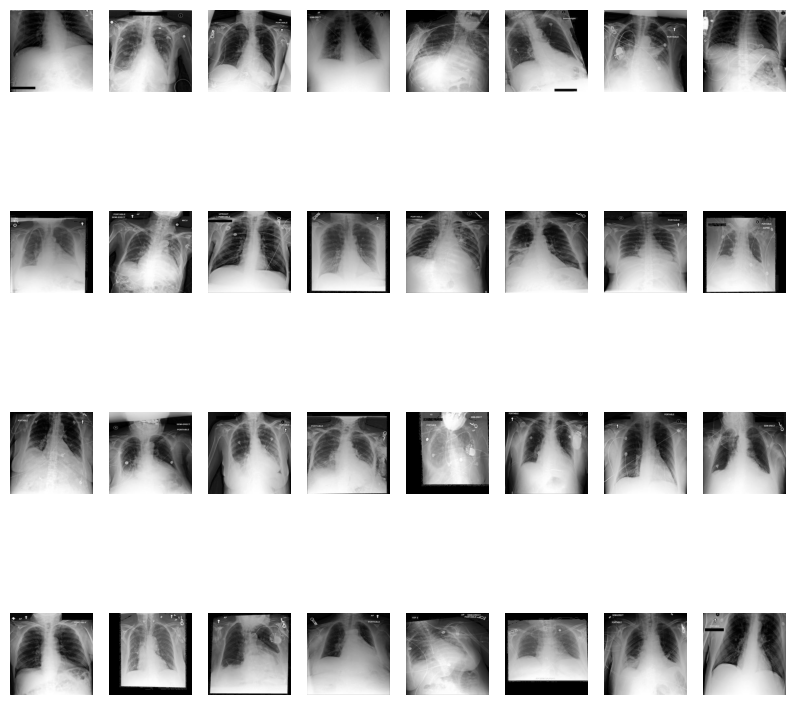

In [14]:
plt.figure(figsize=(10, 10))
for img, label in dataset_val.take(1):
    for n in range(32):
        ax = plt.subplot(4, 8, n+1)
        plt.imshow(img[n], cmap='gray')
        plt.axis("off")

# Model

In [15]:
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)
input_img = Input(input_shape)
x = tf.keras.applications.densenet.preprocess_input(input_img)
base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor = x, pooling = 'avg')
x = base_model(x)
predictions = Dense(1, activation="sigmoid")(x)
model = Model(inputs=input_img, outputs=predictions)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 256, 256, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 256, 256, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
______________________________________________

## Training

In [17]:
callbacks_list = [EarlyStopping(monitor='val_loss',patience=10),
                  ModelCheckpoint(filepath='./model/baseline/baseline.h5',monitor='val_loss',save_best_only=True,),
                  ReduceLROnPlateau(monitor='val_loss',factor=0.2, patience=3)]
initial_learning_rate = 0.001

In [18]:
opt = Adam(learning_rate=initial_learning_rate, epsilon=1e-8)
model.compile(optimizer=opt,loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.BinaryAccuracy()])

In [120]:
# epochs = 30
# history = model.fit(
#     dataset_train,
#     validation_data=dataset_val, 
#     epochs=epochs,
#     verbose=1,
#     callbacks=callbacks_list,
# )